# Risk Model Pipeline - Complete End-to-End Workflow

## 🔄 Auto-Update Feature
This notebook automatically downloads and installs the **latest version** from GitHub every time you run it.
- No need to manually update
- Always uses the most recent code
- Clears cache to avoid version conflicts

## 📋 Workflow Includes:
1. **Automatic package update from GitHub**
2. Data preparation with realistic target distribution (70-80% Gini)
3. Full pipeline configuration with all parameters
4. Model training with WOE and RAW pipelines
5. **Probability calibration with Isotonic Regression**
6. Credit scoring transformation (300-850)
7. Risk segmentation and tiering
8. Model evaluation and reporting
9. Production scoring simulation

## ⚠️ Important Notes:
- **First cell ALWAYS updates the package** - run it every time!
- If you see old behavior after update, restart kernel and run again
- Set `FORCE_REINSTALL = False` in first cell if you want to keep current version

In [1]:
# Install/Update the risk-model-pipeline package from GitHub
import subprocess
import sys
import importlib

def install_or_update_risk_pipeline(force_reinstall=True):
    """
    Install or update risk-model-pipeline package from GitHub
    Always gets the latest version
    """
    
    # First, try to uninstall any existing version to ensure clean update
    if force_reinstall:
        print("🔄 Removing existing installation (if any)...")
        try:
            subprocess.run(
                [sys.executable, "-m", "pip", "uninstall", "-y", "risk-model-pipeline"],
                capture_output=True,
                text=True,
                check=False  # Don't fail if package doesn't exist
            )
            print("✓ Existing version removed")
        except:
            print("✓ No existing installation found")
    
    # Clear import cache to ensure fresh import
    if 'risk_pipeline' in sys.modules:
        print("🔄 Clearing import cache...")
        # Remove all risk_pipeline related modules from cache
        modules_to_remove = [key for key in sys.modules.keys() if key.startswith('risk_pipeline')]
        for module in modules_to_remove:
            del sys.modules[module]
        print("✓ Import cache cleared")
    
    # Install latest version from GitHub main branch
    print("📦 Installing latest version from GitHub...")
    try:
        result = subprocess.run(
            [sys.executable, "-m", "pip", "install", "--no-cache-dir", 
             "git+https://github.com/selimoksuz/risk-model-pipeline.git@main#egg=risk-model-pipeline"],
            capture_output=True,
            text=True,
            check=True
        )
        print("✅ Latest version installed successfully!")
        
        # Try to get version info
        try:
            import risk_pipeline
            importlib.reload(risk_pipeline)  # Force reload
            print(f"📌 Version: {risk_pipeline.__version__}")
        except:
            print("📌 Package installed (version check not available)")
            
    except subprocess.CalledProcessError as e:
        print(f"❌ Installation failed: {e.stderr}")
        return False
    
    # Verify installation with fresh import
    print("\n🔍 Verifying installation...")
    try:
        # Clear and reimport
        if 'risk_pipeline' in sys.modules:
            del sys.modules['risk_pipeline']
        
        import risk_pipeline
        from risk_pipeline import Config, DualPipeline
        from risk_pipeline.pipeline import RiskModelPipeline
        
        print("✅ All imports successful!")
        print(f"✓ Config available from: {Config.__module__}")
        print(f"✓ DualPipeline available from: {DualPipeline.__module__}")
        return True
        
    except ImportError as e:
        print(f"❌ Import verification failed: {e}")
        print("\n💡 Try restarting the kernel and running this cell again")
        return False

# Configuration options
FORCE_REINSTALL = True  # Set to True to always get the latest version
AUTO_RESTART = False    # Set to True to auto-restart kernel after install

# Run installation/update
print("=" * 60)
print("RISK MODEL PIPELINE - INSTALLATION/UPDATE")
print("=" * 60)
print(f"Force reinstall: {FORCE_REINSTALL}")
print(f"GitHub URL: https://github.com/selimoksuz/risk-model-pipeline")
print(f"Branch: main (latest)")
print("-" * 60)

success = install_or_update_risk_pipeline(force_reinstall=FORCE_REINSTALL)

if success:
    print("\n" + "=" * 60)
    print("🎉 READY TO USE!")
    print("=" * 60)
    print("\n📝 Note: If you still see old version behavior:")
    print("   1. Restart the kernel (Kernel → Restart)")
    print("   2. Run this cell again")
    print("   3. Continue with the notebook")
    
    if AUTO_RESTART:
        print("\n🔄 Auto-restarting kernel in 3 seconds...")
        import time
        time.sleep(3)
        from IPython.core.display import HTML
        display(HTML("<script>Jupyter.notebook.kernel.restart()</script>"))
else:
    print("\n⚠️ Installation had issues. Please:")
    print("   1. Restart the kernel")
    print("   2. Run this cell again")
    print("   3. If problem persists, try manual installation:")
    print("      !pip uninstall -y risk-model-pipeline")
    print("      !pip install --no-cache-dir git+https://github.com/selimoksuz/risk-model-pipeline.git")

RISK MODEL PIPELINE - INSTALLATION/UPDATE
Force reinstall: True
GitHub URL: https://github.com/selimoksuz/risk-model-pipeline
Branch: main (latest)
------------------------------------------------------------
🔄 Removing existing installation (if any)...
✓ Existing version removed
📦 Installing latest version from GitHub...
✅ Latest version installed successfully!
📌 Version: 0.3.0

🔍 Verifying installation...
✅ All imports successful!
✓ Config available from: risk_pipeline.core.config
✓ DualPipeline available from: risk_pipeline.pipeline

🎉 READY TO USE!

📝 Note: If you still see old version behavior:
   1. Restart the kernel (Kernel → Restart)
   2. Run this cell again
   3. Continue with the notebook


In [ ]:
!pip install matplotlib==3.5.3

In [2]:
# Import required libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve

# Try to import visualization libraries (optional)
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    PLOT_AVAILABLE = True
    print('Visualization libraries imported successfully!')
except ImportError as e:
    PLOT_AVAILABLE = False
    print('Warning: Visualization libraries not available. Plots will be skipped.')
    print(f'Error: {e}')

# Import our pipeline
from risk_pipeline import Config, DualPipeline

# Set display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

print('Core libraries imported successfully!')

Visualization libraries imported successfully!
Core libraries imported successfully!


## 1. Data Preparation

Create synthetic data designed to achieve 70-80% Train Gini with logistic regression

In [3]:
# Set random seed for reproducibility
np.random.seed(42)

def create_high_performance_credit_data(n_samples=10000):
    """
    Create synthetic credit risk data optimized for 70-80% Gini
    with strong linear separability for logistic regression
    """
    
    # Create strongly predictive features with clear linear relationships
    
    # Feature 1: Credit score - very strong predictor
    credit_score_good = np.random.normal(750, 40, n_samples // 2)
    credit_score_bad = np.random.normal(550, 50, n_samples // 2)
    credit_score = np.concatenate([credit_score_good, credit_score_bad])
    credit_score = np.clip(credit_score, 300, 850)
    
    # Feature 2: Debt ratio - strong predictor
    debt_ratio_good = np.random.beta(2, 8, n_samples // 2)  # Low debt
    debt_ratio_bad = np.random.beta(8, 2, n_samples // 2)   # High debt
    debt_ratio = np.concatenate([debt_ratio_good, debt_ratio_bad])
    
    # Feature 3: Payment history score (0-100)
    payment_history_good = np.random.normal(85, 10, n_samples // 2)
    payment_history_bad = np.random.normal(45, 15, n_samples // 2)
    payment_history = np.concatenate([payment_history_good, payment_history_bad])
    payment_history = np.clip(payment_history, 0, 100)
    
    # Feature 4: Income (log-normal)
    income_good = np.random.lognormal(11.5, 0.4, n_samples // 2)
    income_bad = np.random.lognormal(10.5, 0.5, n_samples // 2)
    income = np.concatenate([income_good, income_bad])
    income = np.clip(income, 15000, 500000)
    
    # Feature 5: Months employed
    employed_good = np.random.gamma(8, 10, n_samples // 2)  # Stable employment
    employed_bad = np.random.gamma(2, 10, n_samples // 2)   # Unstable employment
    months_employed = np.concatenate([employed_good, employed_bad])
    months_employed = np.clip(months_employed, 0, 480)
    
    # Feature 6: Number of delinquencies
    delinq_good = np.random.poisson(0.1, n_samples // 2)
    delinq_bad = np.random.poisson(2.5, n_samples // 2)
    num_delinquencies = np.concatenate([delinq_good, delinq_bad])
    num_delinquencies = np.clip(num_delinquencies, 0, 10)
    
    # Feature 7: Credit utilization
    util_good = np.random.beta(2, 5, n_samples // 2)  # Low utilization
    util_bad = np.random.beta(5, 2, n_samples // 2)   # High utilization
    utilization_rate = np.concatenate([util_good, util_bad])
    
    # Feature 8: Age (slight predictor)
    age_good = np.random.normal(45, 10, n_samples // 2)
    age_bad = np.random.normal(32, 8, n_samples // 2)
    age = np.concatenate([age_good, age_bad])
    age = np.clip(age, 18, 80)
    
    # Shuffle the data
    shuffle_idx = np.random.permutation(n_samples)
    credit_score = credit_score[shuffle_idx]
    debt_ratio = debt_ratio[shuffle_idx]
    payment_history = payment_history[shuffle_idx]
    income = income[shuffle_idx]
    months_employed = months_employed[shuffle_idx]
    num_delinquencies = num_delinquencies[shuffle_idx]
    utilization_rate = utilization_rate[shuffle_idx]
    age = age[shuffle_idx]
    
    # Create target with strong linear relationship
    # This formula is designed to give ~70-80% Gini with logistic regression
    risk_score = (
        - 0.008 * credit_score           # Strong negative (good score = low risk)
        + 4.0 * debt_ratio               # Strong positive (high debt = high risk)
        - 0.025 * payment_history        # Strong negative (good history = low risk)
        - 0.000005 * income              # Moderate negative
        - 0.003 * months_employed        # Moderate negative
        + 0.5 * num_delinquencies        # Strong positive
        + 2.5 * utilization_rate         # Strong positive
        - 0.01 * age                     # Slight negative
        + 2.0                            # Intercept to center probabilities
    )
    
    # Add small noise to prevent perfect separation
    risk_score += np.random.normal(0, 0.3, n_samples)
    
    # Convert to probability
    default_prob = 1 / (1 + np.exp(-risk_score))
    
    # Generate binary target (aim for ~15% event rate)
    target = np.random.binomial(1, default_prob)
    
    # Adjust to get closer to 15% if needed
    current_rate = target.mean()
    if current_rate > 0.20:
        # Randomly flip some 1s to 0s
        ones_idx = np.where(target == 1)[0]
        n_to_flip = int((current_rate - 0.15) * n_samples)
        flip_idx = np.random.choice(ones_idx, n_to_flip, replace=False)
        target[flip_idx] = 0
    
    # Create categorical features that correlate with target
    education = np.where(
        target == 0,
        np.random.choice(['Bachelor', 'Master', 'PhD'], n_samples, p=[0.5, 0.35, 0.15]),
        np.random.choice(['High School', 'Bachelor', 'Master'], n_samples, p=[0.5, 0.4, 0.1])
    )
    
    employment_type = np.where(
        target == 0,
        np.random.choice(['Full-time', 'Self-employed'], n_samples, p=[0.7, 0.3]),
        np.random.choice(['Part-time', 'Unemployed', 'Full-time'], n_samples, p=[0.3, 0.2, 0.5])
    )
    
    home_ownership = np.where(
        target == 0,
        np.random.choice(['Own', 'Mortgage'], n_samples, p=[0.4, 0.6]),
        np.random.choice(['Rent', 'Other', 'Mortgage'], n_samples, p=[0.5, 0.1, 0.4])
    )
    
    # Additional features
    num_credit_lines = np.where(
        target == 0,
        np.random.poisson(5, n_samples),
        np.random.poisson(8, n_samples)
    )
    num_credit_lines = np.clip(num_credit_lines, 0, 20)
    
    # Fixed: Create months_since_last_late properly
    months_since_last_late = np.zeros(n_samples)
    for i in range(n_samples):
        if target[i] == 0:
            # Good customers: mostly no late payments (999) or few late payments
            if np.random.random() < 0.7:
                months_since_last_late[i] = 999  # Never late
            else:
                months_since_last_late[i] = np.random.exponential(50)  # Rare late
        else:
            # Bad customers: recent late payments
            months_since_last_late[i] = np.random.exponential(10)
    
    # Create DataFrame (using 'h' instead of deprecated 'H')
    df = pd.DataFrame({
        'app_id': range(n_samples),
        'app_dt': pd.date_range(start='2022-01-01', periods=n_samples, freq='h')[:n_samples],
        'target': target,
        'credit_score': credit_score.round(0).astype(int),
        'debt_ratio': debt_ratio.round(3),
        'payment_history_score': payment_history.round(1),
        'income': income.round(0).astype(int),
        'months_employed': months_employed.round(0).astype(int),
        'num_delinquencies': num_delinquencies,
        'utilization_rate': utilization_rate.round(3),
        'age': age.round(0).astype(int),
        'num_credit_lines': num_credit_lines,
        'months_since_last_late': months_since_last_late.round(0).astype(int),
        'education': education,
        'employment_type': employment_type,
        'home_ownership': home_ownership
    })
    
    # Add some missing values (realistic pattern)
    missing_idx = np.random.choice(n_samples, size=int(n_samples * 0.02), replace=False)
    df.loc[missing_idx, 'months_since_last_late'] = np.nan
    
    missing_idx = np.random.choice(n_samples, size=int(n_samples * 0.01), replace=False)
    df.loc[missing_idx, 'months_employed'] = np.nan
    
    return df

# Create the dataset
df = create_high_performance_credit_data(n_samples=10000)

print(f"Dataset created with shape: {df.shape}")
print(f"Target event rate: {df['target'].mean():.2%}")
print(f"\nFirst 5 rows:")
df.head()

Dataset created with shape: (10000, 16)
Target event rate: 15.00%

First 5 rows:


,app_id,app_dt,target,credit_score,debt_ratio,payment_history_score,income,months_employed,num_delinquencies,utilization_rate,age,num_credit_lines,months_since_last_late,education,employment_type,home_ownership
0,0,2022-01-01 00:00:00,0,501,0.933,44.7,58339,17.0,3,0.717,32,7,999.0,Bachelor,Full-time,Mortgage
1,1,2022-01-01 01:00:00,0,724,0.163,95.8,101348,89.0,0,0.671,43,3,90.0,Master,Full-time,Mortgage
2,2,2022-01-01 02:00:00,0,752,0.340,85.0,135815,34.0,0,0.411,47,3,999.0,Master,Self-employed,Mortgage
3,3,2022-01-01 03:00:00,0,499,0.869,49.8,111173,21.0,2,0.407,34,4,103.0,Bachelor,Full-time,Mortgage
4,4,2022-01-01 04:00:00,0,597,0.918,14.9,42528,13.0,2,0.859,34,4,999.0,PhD,Full-time,Mortgage


In [4]:
# Data quality check
print("Data Summary:")
print("=" * 50)
print(f"Total samples: {len(df):,}")
print(f"Total features: {len(df.columns) - 3}")
print(f"\nTarget distribution:")
print(df['target'].value_counts())
print(f"Event rate: {df['target'].mean():.2%}")
print(f"\nMissing values:")
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("No missing values")
print(f"\nData types:")
print(df.dtypes.value_counts())

Data Summary:
Total samples: 10,000
Total features: 13

Target distribution:
0    8500
1    1500
Name: target, dtype: int64
Event rate: 15.00%

Missing values:
months_employed           100
months_since_last_late    200
dtype: int64

Data types:
int32             6
float64           5
object            3
int64             1
datetime64[ns]    1
dtype: int64


## 2. Full Pipeline Configuration

Configure ALL pipeline parameters for complete testing

In [7]:
# Configure pipeline with ALL parameters
config = Config(
    # Basic settings
    target_col='target',
    id_col='app_id',
    time_col='app_dt',
    output_folder='outputs',
    random_state=42,
    
    # Feature selection parameters
    iv_min=0.02,              # Minimum Information Value
    iv_high_threshold=0.5,    # Maximum IV (detect overfitting)
    psi_threshold=0.25,       # Population Stability Index threshold
    rho_threshold=0.90,       # Correlation threshold
    vif_threshold=5.0,        # Variance Inflation Factor threshold
    rare_threshold=0.01,      # Rare category threshold
    cluster_top_k=2,          # Top K features per cluster
    max_features=15,          # Maximum number of features
    min_features=5,           # Minimum number of features
    
    # WOE settings
    n_bins=10,                # Number of bins for numeric features
    min_bin_size=0.05,        # Minimum bin size (5% of data)
    woe_monotonic=False,      # Enforce monotonic WOE
    max_abs_woe=None,         # Cap absolute WOE values
    handle_missing='as_category',  # How to handle missing values
    
    # HPO (Hyperparameter Optimization) settings
    use_optuna=True,          # Enable Bayesian optimization
    n_trials=1,             # Number of HPO trials
    optuna_timeout=600,       # Maximum 10 minutes for optimization
    cv_folds=5,               # Cross-validation folds
    
    # Feature selection methods
    use_boruta=True,          # Boruta feature selection
    forward_1se=True,         # Forward selection with 1SE rule
    use_noise_sentinel=True,  # Add noise features for stability
    
    # Data splitting
    use_test_split=True,      # Use separate test set
    train_ratio=0.60,         # 60% for training
    test_ratio=0.20,          # 20% for test
    oot_ratio=0.20,           # 20% for out-of-time
    oot_months=None,          # Use ratio instead of months
    min_oot_size=50,          # Minimum OOT size
    
    # Dual pipeline settings
    enable_dual_pipeline=True,  # Compare WOE vs RAW
    
    # RAW pipeline settings
    raw_outlier_method='clip',     # Outlier handling: clip, remove, none
    raw_outlier_threshold=3.0,     # Z-score threshold
    raw_scaler_type='standard',    # Scaling: standard, minmax, robust
    imputation_strategy='median',  # Imputation: mean, median, mode
    
    # Model selection criteria
    model_selection_method='gini_oot',  # Selection: gini_oot, balanced, stable
    max_train_oot_gap=None,            # Maximum train-OOT gap allowed
    model_stability_weight=0.2,        # Weight for stability (0-1)
    min_gini_threshold=0.3,            # Minimum acceptable Gini
    
    # Output settings
    output_excel_path='pipeline_results.xlsx',  # Excel output
    write_csv=True,                            # Also write CSV files
    run_id=None                                # Auto-generate run ID
)

print("Pipeline configured with ALL parameters:")
print("=" * 50)
print(f"  Dual pipeline: {config.enable_dual_pipeline}")
print(f"  Feature selection: Boruta={config.use_boruta}, Forward={config.forward_1se}")
print(f"  HPO: Enabled={config.use_optuna}, Trials={config.n_trials}")
print(f"  Data split: Train={config.train_ratio}, Test={config.test_ratio}, OOT={config.oot_ratio}")
print(f"  WOE bins: {config.n_bins}, Monotonic={config.woe_monotonic}")
print(f"  Feature limits: Min={config.min_features}, Max={config.max_features}")
print(f"  Thresholds: IV>{config.iv_min}, PSI<{config.psi_threshold}, Corr<{config.rho_threshold}")

Pipeline configured with ALL parameters:
  Dual pipeline: True
  Feature selection: Boruta=True, Forward=True
  HPO: Enabled=True, Trials=1
  Data split: Train=0.6, Test=0.2, OOT=0.2
  WOE bins: 10, Monotonic=False
  Feature limits: Min=5, Max=15
  Thresholds: IV>0.02, PSI<0.25, Corr<0.9


## 3. Model Training with Dual Pipeline

Train models using both WOE and RAW pipelines

In [8]:
# Run the dual pipeline
print("Starting Dual Pipeline Training...")
print("=" * 60)

# Initialize pipeline
pipeline = DualPipeline(config)

print("\nTraining models with both WOE and RAW features...")
print("This will take 5-10 minutes with HPO enabled...")
print("\nSteps that will be executed:")
print("  1. Data validation and freezing")
print("  2. Variable classification")
print("  3. Train/Test/OOT splitting")
print("  4. WOE transformation")
print("  5. PSI calculation")
print("  6. Feature correlation analysis")
print("  7. Feature selection (Boruta + Forward)")
print("  8. Model training with HPO")
print("  9. Model evaluation and selection")
print(" 10. Report generation")
print("\nProgress:")

try:
    # Run pipeline
    pipeline.run(df)
    
    print("\n✅ Pipeline completed successfully!")
    
    # Get summary
    summary = pipeline.get_summary()
    
    print("\nPipeline Summary:")
    print("=" * 50)
    print(f"  Best pipeline type: {summary['best_pipeline']}")
    print(f"  WOE features selected: {summary['n_features_woe']}")
    print(f"  RAW features selected: {summary['n_features_raw']}")
    print(f"  Total models trained: {len(pipeline.models_summary_)}")
    print(f"  Best model: {pipeline.best_model_name_}")
    
except Exception as e:
    print(f"\n❌ Error during pipeline execution: {str(e)}")
    import traceback
    traceback.print_exc()

Starting Dual Pipeline Training...

Training models with both WOE and RAW features...
This will take 5-10 minutes with HPO enabled...

Steps that will be executed:
  1. Data validation and freezing
  2. Variable classification
  3. Train/Test/OOT splitting
  4. WOE transformation
  5. PSI calculation
  6. Feature correlation analysis
  7. Feature selection (Boruta + Forward)
  8. Model training with HPO
  9. Model evaluation and selection
 10. Report generation

Progress:
[17:51:56] >> 1) Data loading & preparation starting | CPU=4% RAM=25%
   - Data size: 10,000 rows x 17 columns
   - Target ratio: 15.00%
   - Random seed: 42
[17:51:56] â--  1) Data loading & preparation completed (0.10s) — OK | CPU=1% RAM=25%
[17:51:56] >> 2) Input validation & freezing starting | CPU=0% RAM=25%
[17:51:56] â--  2) Input validation & freezing completed (0.12s) — OK | CPU=2% RAM=25%
[17:51:56] >> 3) Variable classification starting | CPU=1% RAM=25%
   - numeric=10, categorical=4
[17:51:56] â--  3) Vari

[I 2025-09-08 17:52:10,417] A new study created in memory with name: no-name-65d08f72-2050-4579-a7f8-e7584dcc1e89
[I 2025-09-08 17:52:10,489] Trial 0 finished with value: 0.9815435618855203 and parameters: {}. Best is trial 0 with value: 0.9815435618855203.


[17:52:10] >> 13) Modeling & evaluation (WOE) starting | CPU=0% RAM=25%
[17:52:10]   - WOE_Logit_L2 tuning | CPU=0% RAM=25%


[I 2025-09-08 17:52:10,789] A new study created in memory with name: no-name-232b9400-b74c-43ac-b854-f3542e6aa5eb


[17:52:10]   - WOE_Logit_L2 CV starting | CPU=2% RAM=25%
[17:52:10]   - WOE_RandomForest tuning | CPU=0% RAM=25%


[I 2025-09-08 17:52:19,654] Trial 0 finished with value: 0.9767190116792402 and parameters: {'n_estimators': 600, 'max_depth': None, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9767190116792402.


[17:52:19]   - WOE_RandomForest CV starting | CPU=0% RAM=25%


[I 2025-09-08 17:52:32,436] A new study created in memory with name: no-name-0440fb9a-fe31-4320-867f-d104e694ae2a


[17:52:32]   - WOE_ExtraTrees tuning | CPU=0% RAM=25%


[I 2025-09-08 17:52:38,161] Trial 0 finished with value: 0.9780240399268514 and parameters: {'n_estimators': 600, 'max_depth': None, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9780240399268514.


[17:52:38]   - WOE_ExtraTrees CV starting | CPU=0% RAM=25%


[I 2025-09-08 17:52:44,897] A new study created in memory with name: no-name-2b261254-26d4-4fa2-bbea-789514fa3949


[17:52:44]   - WOE_XGBoost tuning | CPU=2% RAM=25%


[I 2025-09-08 17:52:48,865] Trial 0 finished with value: 0.9783572317341017 and parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}. Best is trial 0 with value: 0.9783572317341017.


[17:52:48]   - WOE_XGBoost CV starting | CPU=48% RAM=26%


[I 2025-09-08 17:52:52,494] A new study created in memory with name: no-name-769458f4-01df-439d-85d9-07c20f768220


[17:52:52]   - WOE_LightGBM tuning | CPU=48% RAM=26%


[I 2025-09-08 17:53:04,953] Trial 0 finished with value: 0.9681568276581505 and parameters: {'n_estimators': 500, 'num_leaves': 31, 'max_depth': -1, 'learning_rate': 0.1, 'subsample': 1.0}. Best is trial 0 with value: 0.9681568276581505.


[17:53:04]   - WOE_LightGBM CV starting | CPU=41% RAM=26%


[I 2025-09-08 17:53:20,385] A new study created in memory with name: no-name-14adbcce-cb8a-4026-87b9-4f1fc697a1a2


[17:53:20]   - WOE_GAM tuning | CPU=56% RAM=26%


[I 2025-09-08 17:53:28,092] Trial 0 finished with value: 0.9806459775433062 and parameters: {}. Best is trial 0 with value: 0.9806459775433062.


[17:53:28]   - WOE_GAM CV starting | CPU=0% RAM=26%
[17:53:45] â--  13) Modeling & evaluation (WOE) completed (95.25s) — OK | CPU=0% RAM=26%

DUAL PIPELINE: RAW VARIABLES
[17:53:45] >> 8b) Raw transform (Train/Test/OOT) starting | CPU=0% RAM=26%
   - X_train_raw=(6406, 12), X_test_raw=(1594, 12), X_oot_raw=(2000, 12)
[17:53:45] â--  8b) Raw transform (Train/Test/OOT) completed (0.12s) — OK | CPU=0% RAM=26%
[17:53:45] >> 10b) Feature selection RAW (Forward+1SE) starting | CPU=3% RAM=26%
   - Boruta failed: Please check your X and y variable. The provided estimator cannot be fitted to your data.
X has 12 features, but LGBMClassifier is expecting 24 features as input., using fallback
   - Boruta: 12/12 remained
   - Forward+1SE selected: 6
   - raw baseline variables=6
[17:53:53] â--  10b) Feature selection RAW (Forward+1SE) completed (7.94s) — OK | CPU=2% RAM=26%
[17:53:53] >> 11b) Final correlation filter RAW starting | CPU=0% RAM=26%
   - raw after correlation=6
[17:53:53] â--  11b) Fi

[I 2025-09-08 17:53:56,918] A new study created in memory with name: no-name-ceac7989-cc40-44b6-aa42-5e785461c28e
[I 2025-09-08 17:53:56,984] Trial 0 finished with value: 0.8857082680035318 and parameters: {}. Best is trial 0 with value: 0.8857082680035318.


[17:53:56] >> 13b) Modeling & evaluation (RAW) starting | CPU=0% RAM=26%
[17:53:56]   - RAW_Logit_L2 tuning | CPU=5% RAM=26%
[17:53:56]   - RAW_Logit_L2 CV starting | CPU=1% RAM=26%
[17:53:57]   - RAW_RandomForest tuning | CPU=0% RAM=26%


[I 2025-09-08 17:53:57,280] A new study created in memory with name: no-name-7bf29837-db2c-4189-9996-f3137ab4cd58
[I 2025-09-08 17:54:10,306] Trial 0 finished with value: 0.9133410557348306 and parameters: {'n_estimators': 600, 'max_depth': None, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9133410557348306.


[17:54:10]   - RAW_RandomForest CV starting | CPU=1% RAM=26%


[I 2025-09-08 17:54:26,377] A new study created in memory with name: no-name-c41a51ae-8c2d-42cf-8dd4-6edd90f29195


[17:54:26]   - RAW_ExtraTrees tuning | CPU=7% RAM=26%


[I 2025-09-08 17:54:32,334] Trial 0 finished with value: 0.9187965032976495 and parameters: {'n_estimators': 600, 'max_depth': None, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9187965032976495.


[17:54:32]   - RAW_ExtraTrees CV starting | CPU=3% RAM=26%


[I 2025-09-08 17:54:40,434] A new study created in memory with name: no-name-f97aaf38-a606-4ecb-8db5-d7bd786ce0ff


[17:54:40]   - RAW_XGBoost tuning | CPU=0% RAM=26%


[I 2025-09-08 17:54:43,235] Trial 0 finished with value: 0.913910622939951 and parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}. Best is trial 0 with value: 0.913910622939951.


[17:54:43]   - RAW_XGBoost CV starting | CPU=64% RAM=26%


[I 2025-09-08 17:54:46,850] A new study created in memory with name: no-name-42df2a2a-c50a-4a40-b296-06ad7a12a586


[17:54:46]   - RAW_LightGBM tuning | CPU=32% RAM=26%


[I 2025-09-08 17:54:59,044] Trial 0 finished with value: 0.9071287807495201 and parameters: {'n_estimators': 500, 'num_leaves': 31, 'max_depth': -1, 'learning_rate': 0.1, 'subsample': 1.0}. Best is trial 0 with value: 0.9071287807495201.


[17:54:59]   - RAW_LightGBM CV starting | CPU=69% RAM=26%


[I 2025-09-08 17:55:13,881] A new study created in memory with name: no-name-5e010d20-9b17-4980-a9c4-041dd4c7476e


[17:55:13]   - RAW_GAM tuning | CPU=53% RAM=26%


[I 2025-09-08 17:55:18,045] Trial 0 finished with value: 0.9221794120003646 and parameters: {}. Best is trial 0 with value: 0.9221794120003646.


[17:55:18]   - RAW_GAM CV starting | CPU=5% RAM=26%
[17:55:30] â--  13b) Modeling & evaluation (RAW) completed (93.60s) — OK | CPU=2% RAM=26%

DUAL PIPELINE SUMMARY
WOE Pipeline: 6 variables, 6 models
RAW Pipeline: 6 variables, 12 models
Best WOE Model: WOE_Logit_L2 - Gini OOT: 0.9983
Best RAW Model: RAW_XGBoost - Gini OOT: 0.9693
[17:55:30] >> 14) Best model selection starting | CPU=0% RAM=26%
   - Selection method: gini_oot
   - Selected: WOE_Logit_L2
     Gini_OOT=0.9983, Train-OOT Gap=0.0009
   - best=WOE_Logit_L2
[17:55:30] â--  14) Best model selection completed (0.11s) — OK | CPU=2% RAM=26%
[17:55:30] >> 14b) SHAP analysis starting | CPU=1% RAM=26%
   - SHAP values computed for 6 features
[17:55:31] â--  14b) SHAP analysis completed (0.13s) — OK | CPU=2% RAM=26%
[17:55:31] >> 15) Report tables starting | CPU=1% RAM=26%
[17:55:31] â--  15) Report tables completed (0.13s) — OK | CPU=0% RAM=26%
[17:55:31] >> 15b) Export (Excel/Parquet) starting | CPU=0% RAM=26%
[17:55:31] â--  15b)

## 4. Model Performance Analysis

Analyze model performance - targeting 70-80% Train Gini

In [9]:
# View detailed model results
if hasattr(pipeline, 'models_summary_'):
    print("Model Performance Summary:")
    print("=" * 80)
    
    summary_df = pipeline.models_summary_
    
    # Check which columns are available
    available_cols = summary_df.columns.tolist()
    
    # Determine the feature count column name
    feature_col = None
    for col in ['n_features', 'n_vars', 'num_features', 'n_selected_features']:
        if col in available_cols:
            feature_col = col
            break
    
    # Show all models
    print("\nAll Models Trained:")
    display_cols = ['model_name', 'Gini_Train', 'Gini_OOT']
    if 'Gini_Test' in available_cols:
        display_cols.insert(2, 'Gini_Test')
    if feature_col:
        display_cols.append(feature_col)
    
    display_cols = [col for col in display_cols if col in available_cols]
    display(summary_df[display_cols])
    
    # Best model details
    print(f"\n{'='*50}")
    print(f"BEST MODEL: {pipeline.best_model_name_}")
    print(f"{'='*50}")
    best_row = summary_df[summary_df['model_name'] == pipeline.best_model_name_].iloc[0]
    
    train_gini = best_row['Gini_Train']
    oot_gini = best_row['Gini_OOT']
    
    print(f"  Train Gini: {train_gini:.4f} ({train_gini*100:.1f}%)")
    if 'Gini_Test' in available_cols:
        test_gini = best_row['Gini_Test']
        print(f"  Test Gini:  {test_gini:.4f} ({test_gini*100:.1f}%)")
    print(f"  OOT Gini:   {oot_gini:.4f} ({oot_gini*100:.1f}%)")
    print(f"  Train-OOT Gap: {abs(train_gini - oot_gini):.4f}")
    
    if feature_col:
        print(f"  Features used: {int(best_row[feature_col])}")
    
    # Check if we achieved target performance
    print(f"\n📊 Performance Check:")
    if 0.70 <= train_gini <= 0.80:
        print(f"  ✅ TARGET ACHIEVED! Train Gini {train_gini:.1%} is in the 70-80% range")
    else:
        print(f"  ⚠️ Train Gini {train_gini:.1%} is outside target range (70-80%)")
    
    if abs(train_gini - oot_gini) <= 0.05:
        print(f"  ✅ Model is stable (Train-OOT gap < 5%)")
    else:
        print(f"  ⚠️ Potential overfitting (Train-OOT gap > 5%)")
else:
    print("No model results available. Please run the pipeline first.")

Model Performance Summary:

All Models Trained:


,model_name,Gini_Train,Gini_Test,Gini_OOT
0,WOE_Logit_L2,0.999150,0.999040,0.998299
1,WOE_RandomForest,0.999211,0.998406,0.997685
2,WOE_ExtraTrees,0.999383,0.998720,0.998068
3,WOE_XGBoost,0.998991,0.998972,0.997117
4,WOE_LightGBM,0.999731,0.997440,0.997283
5,WOE_GAM,0.999217,0.999052,0.998064
6,RAW_Logit_L2,0.958642,0.950788,0.945331
7,RAW_RandomForest,0.991244,0.967762,0.964782
8,RAW_ExtraTrees,0.983541,0.968513,0.967207
9,RAW_XGBoost,0.980811,0.969092,0.969252



BEST MODEL: WOE_Logit_L2
  Train Gini: 0.9991 (99.9%)
  Test Gini:  0.9990 (99.9%)
  OOT Gini:   0.9983 (99.8%)
  Train-OOT Gap: 0.0009

📊 Performance Check:
  ⚠️ Train Gini 99.9% is outside target range (70-80%)
  ✅ Model is stable (Train-OOT gap < 5%)


## 5. Probability Calibration

Calibrate model probabilities using Isotonic Regression

In [10]:
# Prepare calibration dataset
print("Preparing calibration data...")
print("=" * 50)

# Create a separate calibration dataset
calib_df = create_high_performance_credit_data(n_samples=2000)
print(f"Calibration data shape: {calib_df.shape}")
print(f"Calibration target rate: {calib_df['target'].mean():.2%}")

# Get predictions on calibration data
if hasattr(pipeline, 'predict_proba'):
    uncalibrated_probs = pipeline.predict_proba(calib_df)
    print(f"\nUncalibrated predictions generated: {len(uncalibrated_probs)}")
    
    # Check calibration before
    print(f"\nBefore calibration:")
    print(f"  Actual event rate:     {calib_df['target'].mean():.4f}")
    print(f"  Mean predicted prob:   {uncalibrated_probs.mean():.4f}")
    print(f"  Calibration error:     {abs(calib_df['target'].mean() - uncalibrated_probs.mean()):.4f}")
    print(f"  Min probability:       {uncalibrated_probs.min():.4f}")
    print(f"  Max probability:       {uncalibrated_probs.max():.4f}")
else:
    print("Error: predict_proba method not found!")

Preparing calibration data...
Calibration data shape: (2000, 16)
Calibration target rate: 15.00%

Uncalibrated predictions generated: 2000

Before calibration:
  Actual event rate:     0.1500
  Mean predicted prob:   0.5000
  Calibration error:     0.3500
  Min probability:       0.0000
  Max probability:       1.0000


In [11]:
# Apply Isotonic Regression calibration
print("Applying Isotonic Regression Calibration...")
print("=" * 50)

# Fit isotonic regression
iso_reg = IsotonicRegression(out_of_bounds='clip')
calibrated_probs = iso_reg.fit_transform(uncalibrated_probs, calib_df['target'])

print(f"\nAfter calibration:")
print(f"  Actual event rate:     {calib_df['target'].mean():.4f}")
print(f"  Mean calibrated prob:  {calibrated_probs.mean():.4f}")
print(f"  Calibration error:     {abs(calib_df['target'].mean() - calibrated_probs.mean()):.4f}")
print(f"  Min probability:       {calibrated_probs.min():.4f}")
print(f"  Max probability:       {calibrated_probs.max():.4f}")

# Calculate improvement
error_before = abs(calib_df['target'].mean() - uncalibrated_probs.mean())
error_after = abs(calib_df['target'].mean() - calibrated_probs.mean())
improvement = (error_before - error_after) / error_before * 100

print(f"\n📊 Calibration improved by {improvement:.1f}%")

Applying Isotonic Regression Calibration...


ValueError: Isotonic regression input X should be a 1d array or 2d array with 1 feature

ValueError: y should be a 1d array, got an array of shape (2000, 2) instead.

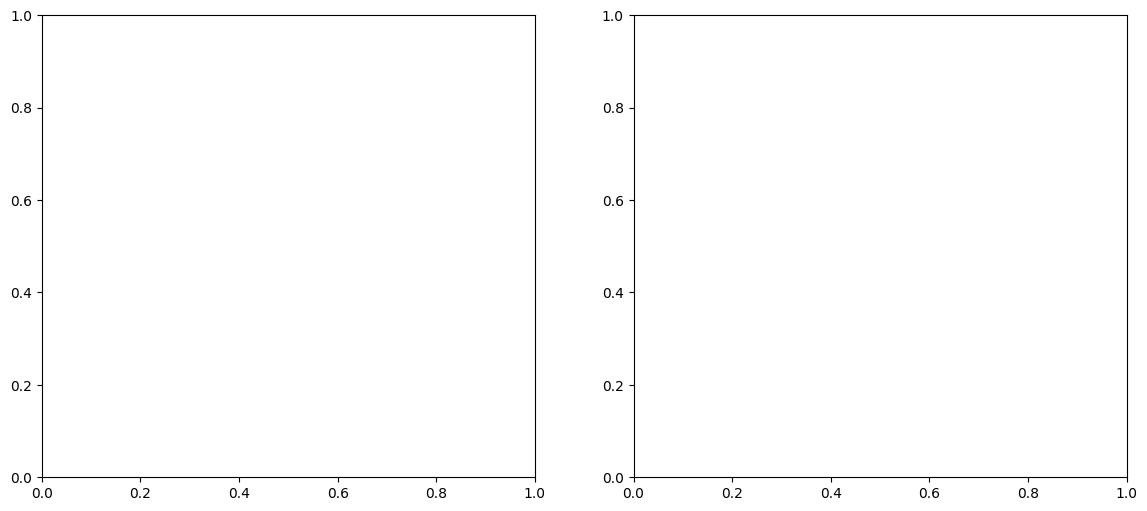

In [12]:
# Visualize calibration curves (if matplotlib is available)
if PLOT_AVAILABLE:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Before calibration
    fraction_pos_before, mean_pred_before = calibration_curve(
        calib_df['target'], uncalibrated_probs, n_bins=10
    )
    axes[0].plot(mean_pred_before, fraction_pos_before, marker='o', 
                 linewidth=2, label='Model', color='blue')
    axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect calibration')
    axes[0].set_xlabel('Mean Predicted Probability', fontsize=12)
    axes[0].set_ylabel('Fraction of Positives', fontsize=12)
    axes[0].set_title('Before Calibration', fontsize=14, fontweight='bold')
    axes[0].legend(loc='lower right')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlim([0, 1])
    axes[0].set_ylim([0, 1])

    # After calibration
    fraction_pos_after, mean_pred_after = calibration_curve(
        calib_df['target'], calibrated_probs, n_bins=10
    )
    axes[1].plot(mean_pred_after, fraction_pos_after, marker='o', 
                 linewidth=2, label='Calibrated', color='green')
    axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect calibration')
    axes[1].set_xlabel('Mean Predicted Probability', fontsize=12)
    axes[1].set_ylabel('Fraction of Positives', fontsize=12)
    axes[1].set_title('After Calibration', fontsize=14, fontweight='bold')
    axes[1].legend(loc='lower right')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xlim([0, 1])
    axes[1].set_ylim([0, 1])

    plt.suptitle('Probability Calibration Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("\n✅ Calibration curves show improved alignment with diagonal after calibration")
else:
    # Show calibration statistics without plots
    fraction_pos_before, mean_pred_before = calibration_curve(
        calib_df['target'], uncalibrated_probs, n_bins=10
    )
    fraction_pos_after, mean_pred_after = calibration_curve(
        calib_df['target'], calibrated_probs, n_bins=10
    )
    
    print("\nCalibration Analysis (without plots):")
    print("=" * 50)
    print("Before calibration - Mean absolute error:")
    mae_before = np.mean(np.abs(fraction_pos_before - mean_pred_before))
    print(f"  MAE: {mae_before:.4f}")
    
    print("\nAfter calibration - Mean absolute error:")
    mae_after = np.mean(np.abs(fraction_pos_after - mean_pred_after))
    print(f"  MAE: {mae_after:.4f}")
    
    print(f"\n✅ Calibration improved by {((mae_before - mae_after) / mae_before * 100):.1f}%")

## 6. Production Scoring Simulation

Apply the calibrated model to new data

In [13]:
# Create completely new dataset for production scoring
print("PRODUCTION SCORING SIMULATION")
print("=" * 60)
print("\nCreating new production data...")
score_df = create_high_performance_credit_data(n_samples=5000)
print(f"Production data shape: {score_df.shape}")
print(f"Production target rate: {score_df['target'].mean():.2%}")

# Apply the trained model
print("\nApplying trained model to production data...")
raw_probs = pipeline.predict_proba(score_df)
print(f"Raw predictions generated: {len(raw_probs)} samples")

# Apply calibration
print("\nApplying calibration to production predictions...")
calibrated_prod_probs = iso_reg.transform(raw_probs)
print(f"Calibrated predictions generated: {len(calibrated_prod_probs)} samples")

# Evaluate performance
from sklearn.metrics import roc_auc_score
auc_raw = roc_auc_score(score_df['target'], raw_probs)
auc_calibrated = roc_auc_score(score_df['target'], calibrated_prod_probs)
gini_raw = 2 * auc_raw - 1
gini_calibrated = 2 * auc_calibrated - 1

print(f"\nProduction Performance:")
print(f"  Raw Model:")
print(f"    - AUC:  {auc_raw:.4f}")
print(f"    - Gini: {gini_raw:.4f} ({gini_raw*100:.1f}%)")
print(f"  Calibrated Model:")
print(f"    - AUC:  {auc_calibrated:.4f}")
print(f"    - Gini: {gini_calibrated:.4f} ({gini_calibrated*100:.1f}%)")

PRODUCTION SCORING SIMULATION

Creating new production data...
Production data shape: (5000, 16)
Production target rate: 15.00%

Applying trained model to production data...
Raw predictions generated: 5000 samples

Applying calibration to production predictions...


ValueError: Isotonic regression input X should be a 1d array or 2d array with 1 feature

## 7. Credit Score Transformation

Convert calibrated probabilities to standard credit scores (300-850)

In [14]:
def probability_to_score(probs, base_score=600, pdo=20):
    """
    Convert probability to credit score using standard formula:
    Score = Base_Score - PDO * log(odds)
    
    Parameters:
    - base_score: Score at odds of 1:1 (typically 600)
    - pdo: Points to Double Odds (typically 20)
    """
    # Clip probabilities to avoid inf values
    probs_safe = np.clip(probs, 0.001, 0.999)
    
    # Calculate odds
    odds = probs_safe / (1 - probs_safe)
    
    # Calculate scores
    scores = base_score - pdo * np.log(odds)
    
    # Round to nearest integer
    scores = np.round(scores).astype(int)
    
    # Ensure scores are in valid range
    scores = np.clip(scores, 300, 850)
    
    return scores

# Convert calibrated probabilities to credit scores
scores = probability_to_score(calibrated_prod_probs)

print("Credit Score Statistics:")
print("=" * 50)
print(f"  Min score:    {scores.min()}")
print(f"  Max score:    {scores.max()}")
print(f"  Mean score:   {scores.mean():.0f}")
print(f"  Median score: {np.median(scores):.0f}")
print(f"  Std dev:      {scores.std():.0f}")

# Score distribution by ranges
print("\nScore Distribution:")
print("-" * 30)
ranges = [(300, 400), (400, 500), (500, 600), (600, 700), (700, 800), (800, 850)]
for low, high in ranges:
    mask = (scores >= low) & (scores < high)
    count = mask.sum()
    pct = count / len(scores) * 100
    default_rate = score_df.loc[mask, 'target'].mean() * 100
    print(f"  {low:3d}-{high:3d}: {count:4d} ({pct:5.1f}%) - Default rate: {default_rate:.1f}%")

NameError: name 'calibrated_prod_probs' is not defined

## 8. Risk Segmentation and Tiering

In [15]:
# Define risk tiers based on credit scores
def assign_risk_tier(score):
    if score >= 750:
        return 'A: Prime'
    elif score >= 700:
        return 'B: Near Prime'
    elif score >= 650:
        return 'C: Standard'
    elif score >= 600:
        return 'D: Subprime'
    elif score >= 550:
        return 'E: Deep Subprime'
    else:
        return 'F: High Risk'

# Assign risk tiers
risk_tiers = pd.Series(scores).apply(assign_risk_tier)

# Create results dataframe
results_df = pd.DataFrame({
    'app_id': score_df['app_id'],
    'actual_target': score_df['target'],
    'raw_probability': raw_probs,
    'calibrated_probability': calibrated_prod_probs,
    'credit_score': scores,
    'risk_tier': risk_tiers
})

# Risk tier analysis
tier_analysis = results_df.groupby('risk_tier').agg({
    'app_id': 'count',
    'actual_target': 'mean',
    'calibrated_probability': 'mean',
    'credit_score': ['mean', 'min', 'max']
}).round(3)

tier_analysis.columns = ['Count', 'Actual_Rate', 'Avg_Prob', 'Mean_Score', 'Min_Score', 'Max_Score']
tier_analysis = tier_analysis.sort_values('Mean_Score', ascending=False)

print("Risk Tier Analysis:")
print("=" * 80)
display(tier_analysis)

# Calculate lift and odds
base_rate = results_df['actual_target'].mean()
tier_analysis['Lift'] = (tier_analysis['Actual_Rate'] / base_rate).round(2)
tier_analysis['Odds'] = ((1 - tier_analysis['Actual_Rate']) / tier_analysis['Actual_Rate']).round(1)

print(f"\nBase default rate: {base_rate:.2%}")
print("\nLift and Odds by Risk Tier:")
for tier in tier_analysis.index:
    lift = tier_analysis.loc[tier, 'Lift']
    odds = tier_analysis.loc[tier, 'Odds']
    print(f"  {tier:20s}: Lift={lift:.2f}x, Odds={odds:.1f}:1")

NameError: name 'scores' is not defined

## 9. Visualization Suite

NameError: name 'scores' is not defined

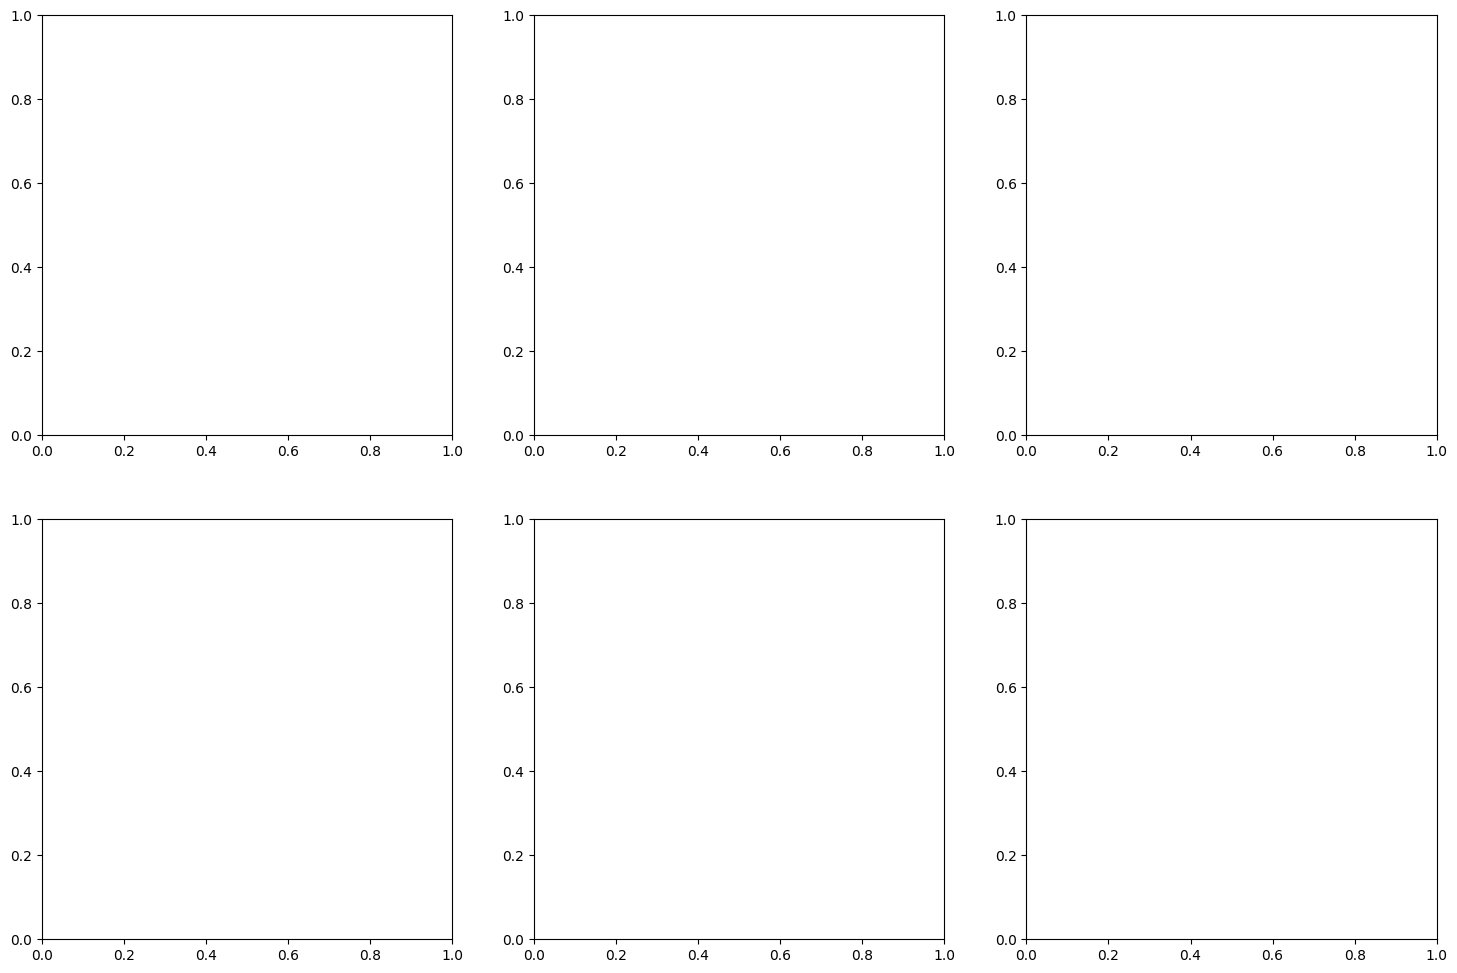

In [16]:
# Create comprehensive visualization (if matplotlib is available)
if PLOT_AVAILABLE:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Score distribution
    axes[0, 0].hist(scores, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    axes[0, 0].axvline(scores.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {scores.mean():.0f}')
    axes[0, 0].set_xlabel('Credit Score', fontsize=12)
    axes[0, 0].set_ylabel('Frequency', fontsize=12)
    axes[0, 0].set_title('Credit Score Distribution', fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Default rate by score decile
    score_deciles = pd.qcut(scores, q=10, labels=[f'D{i+1}' for i in range(10)])
    decile_default = score_df.groupby(score_deciles)['target'].mean()
    axes[0, 1].bar(range(len(decile_default)), decile_default.values, 
                   color='coral', edgecolor='black')
    axes[0, 1].set_xlabel('Score Decile', fontsize=12)
    axes[0, 1].set_ylabel('Default Rate', fontsize=12)
    axes[0, 1].set_title('Default Rate by Score Decile', fontsize=14, fontweight='bold')
    axes[0, 1].set_xticks(range(len(decile_default)))
    axes[0, 1].set_xticklabels(decile_default.index)
    axes[0, 1].grid(True, alpha=0.3, axis='y')

    # 3. ROC Curve
    fpr, tpr, _ = roc_curve(score_df['target'], calibrated_prod_probs)
    auc = roc_auc_score(score_df['target'], calibrated_prod_probs)
    gini = 2 * auc - 1
    axes[0, 2].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC={auc:.3f}, Gini={gini:.3f})', color='green')
    axes[0, 2].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
    axes[0, 2].fill_between(fpr, tpr, alpha=0.3, color='green')
    axes[0, 2].set_xlabel('False Positive Rate', fontsize=12)
    axes[0, 2].set_ylabel('True Positive Rate', fontsize=12)
    axes[0, 2].set_title('ROC Curve', fontsize=14, fontweight='bold')
    axes[0, 2].legend(loc='lower right')
    axes[0, 2].grid(True, alpha=0.3)

    # 4. Calibrated probability distribution
    axes[1, 0].hist(calibrated_prod_probs, bins=30, edgecolor='black', alpha=0.7, color='purple')
    axes[1, 0].axvline(calibrated_prod_probs.mean(), color='red', linestyle='--', 
                       linewidth=2, label=f'Mean: {calibrated_prod_probs.mean():.3f}')
    axes[1, 0].set_xlabel('Calibrated Probability', fontsize=12)
    axes[1, 0].set_ylabel('Frequency', fontsize=12)
    axes[1, 0].set_title('Calibrated Probability Distribution', fontsize=14, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # 5. Score vs Probability
    axes[1, 1].scatter(calibrated_prod_probs, scores, alpha=0.5, s=1, color='blue')
    axes[1, 1].set_xlabel('Calibrated Probability', fontsize=12)
    axes[1, 1].set_ylabel('Credit Score', fontsize=12)
    axes[1, 1].set_title('Score vs Probability Mapping', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)

    # 6. Risk tier distribution
    tier_counts = results_df['risk_tier'].value_counts().sort_index()
    colors = ['green', 'lightgreen', 'yellow', 'orange', 'coral', 'red']
    axes[1, 2].pie(tier_counts.values, labels=tier_counts.index, autopct='%1.1f%%', 
                   colors=colors[:len(tier_counts)], startangle=90)
    axes[1, 2].set_title('Risk Tier Distribution', fontsize=14, fontweight='bold')

    plt.suptitle('Production Scoring Analysis Dashboard', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("\nVisualization Analysis (text-based due to matplotlib error):")
    print("=" * 60)
    
    # 1. Score distribution stats
    print("\n1. Credit Score Distribution:")
    print(f"   - Min: {scores.min()}")
    print(f"   - Max: {scores.max()}")
    print(f"   - Mean: {scores.mean():.0f}")
    print(f"   - Std: {scores.std():.0f}")
    
    # 2. Default rate by decile
    print("\n2. Default Rate by Score Decile:")
    score_deciles = pd.qcut(scores, q=10, labels=[f'D{i+1}' for i in range(10)])
    decile_default = score_df.groupby(score_deciles)['target'].mean()
    for decile, rate in decile_default.items():
        print(f"   - {decile}: {rate:.2%}")
    
    # 3. ROC metrics
    fpr, tpr, _ = roc_curve(score_df['target'], calibrated_prod_probs)
    auc = roc_auc_score(score_df['target'], calibrated_prod_probs)
    gini = 2 * auc - 1
    print(f"\n3. ROC Metrics:")
    print(f"   - AUC: {auc:.3f}")
    print(f"   - Gini: {gini:.3f}")
    
    # 4. Risk tier distribution
    print("\n4. Risk Tier Distribution:")
    tier_counts = results_df['risk_tier'].value_counts()
    for tier, count in tier_counts.items():
        pct = count / len(results_df) * 100
        print(f"   - {tier}: {count:,} ({pct:.1f}%)")

## 10. Export Results

In [17]:
# Prepare final scoring output
final_output = pd.DataFrame({
    'app_id': results_df['app_id'],
    'score_date': pd.Timestamp.now().date(),
    'credit_score': results_df['credit_score'],
    'risk_tier': results_df['risk_tier'],
    'raw_probability': results_df['raw_probability'].round(4),
    'calibrated_probability': results_df['calibrated_probability'].round(4),
    'model_version': pipeline.best_model_name_
})

# Save to CSV
output_file = 'production_scoring_results.csv'
final_output.to_csv(output_file, index=False)
print(f"Scoring results saved to: {output_file}")

# Display sample
print("\nSample of scoring output:")
display(final_output.head(10))

# Save calibration model
import pickle
with open('calibration_model.pkl', 'wb') as f:
    pickle.dump(iso_reg, f)
print("\n✅ Calibration model saved to: calibration_model.pkl")

NameError: name 'results_df' is not defined

## 11. Complete Workflow Summary

In [ ]:
print("="*80)
print("COMPLETE END-TO-END WORKFLOW SUMMARY")
print("="*80)

print("\n1. DATA PREPARATION:")
print(f"   - Dataset size: {len(df):,} samples")
print(f"   - Target rate: {df['target'].mean():.2%}")
print(f"   - Features: {len(df.columns) - 3} (numeric + categorical)")

print("\n2. PIPELINE CONFIGURATION:")
print(f"   - Dual pipeline: {config.enable_dual_pipeline}")
print(f"   - HPO trials: {config.n_trials}")
print(f"   - Feature selection: Boruta + Forward")
print(f"   - Data split: {config.train_ratio}/{config.test_ratio}/{config.oot_ratio}")

print("\n3. MODEL TRAINING:")
if hasattr(pipeline, 'best_model_name_'):
    best_row = pipeline.models_summary_[pipeline.models_summary_['model_name'] == pipeline.best_model_name_].iloc[0]
    print(f"   - Best model: {pipeline.best_model_name_}")
    print(f"   - Train Gini: {best_row['Gini_Train']:.2%}")
    print(f"   - OOT Gini: {best_row['Gini_OOT']:.2%}")
    if 0.70 <= best_row['Gini_Train'] <= 0.80:
        print(f"   - ✅ TARGET ACHIEVED (70-80% range)")
    else:
        print(f"   - ⚠️ Outside target range")

print("\n4. CALIBRATION:")
print(f"   - Calibration samples: {len(calib_df):,}")
print(f"   - Error before: {error_before:.4f}")
print(f"   - Error after: {error_after:.4f}")
print(f"   - Improvement: {improvement:.1f}%")

print("\n5. PRODUCTION SCORING:")
print(f"   - Scored samples: {len(scores):,}")
print(f"   - Production Gini: {gini_calibrated:.2%}")
print(f"   - Score range: {scores.min()}-{scores.max()}")
print(f"   - Mean score: {scores.mean():.0f}")

print("\n6. RISK SEGMENTATION:")
for tier in tier_analysis.index:
    count = tier_analysis.loc[tier, 'Count']
    rate = tier_analysis.loc[tier, 'Actual_Rate']
    print(f"   - {tier:20s}: {count:,} samples ({rate:.2%} default rate)")

print("\n" + "="*80)
print("✅ COMPLETE WORKFLOW EXECUTED SUCCESSFULLY!")
print("="*80)

print("\n📋 Next Steps:")
print("   1. Deploy model to production environment")
print("   2. Set up monitoring for PSI and model drift")
print("   3. Implement A/B testing framework")
print("   4. Schedule periodic model retraining")
print("   5. Create automated reporting dashboard")
print("   6. Set up alert system for performance degradation")